In [17]:
from backend.data.DataSetManager import DataSetManager
import torch
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Use Cuda GPU if available to speed up process, else just use the CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Check device used
device

'cpu'

# Move data to raw data directory, transform, and load data

In [19]:
# Load the brain MRI dataset using Kaggle's API
dataset = DataSetManager()
# Download and move the dataset to 'backend/data/raw/brain_tumor_mri_dataset' if not already downloaded and moved
dataset.download_and_move_dataset()
# Transform data and split to train, validation, and testing sets
train_dataset, test_dataset, train_loader, val_loader, test_loader = dataset.load_data()

Dataset already exists at: ../data/raw/brain_tumor_mri_dataset/. Skipping download.


# Visualization

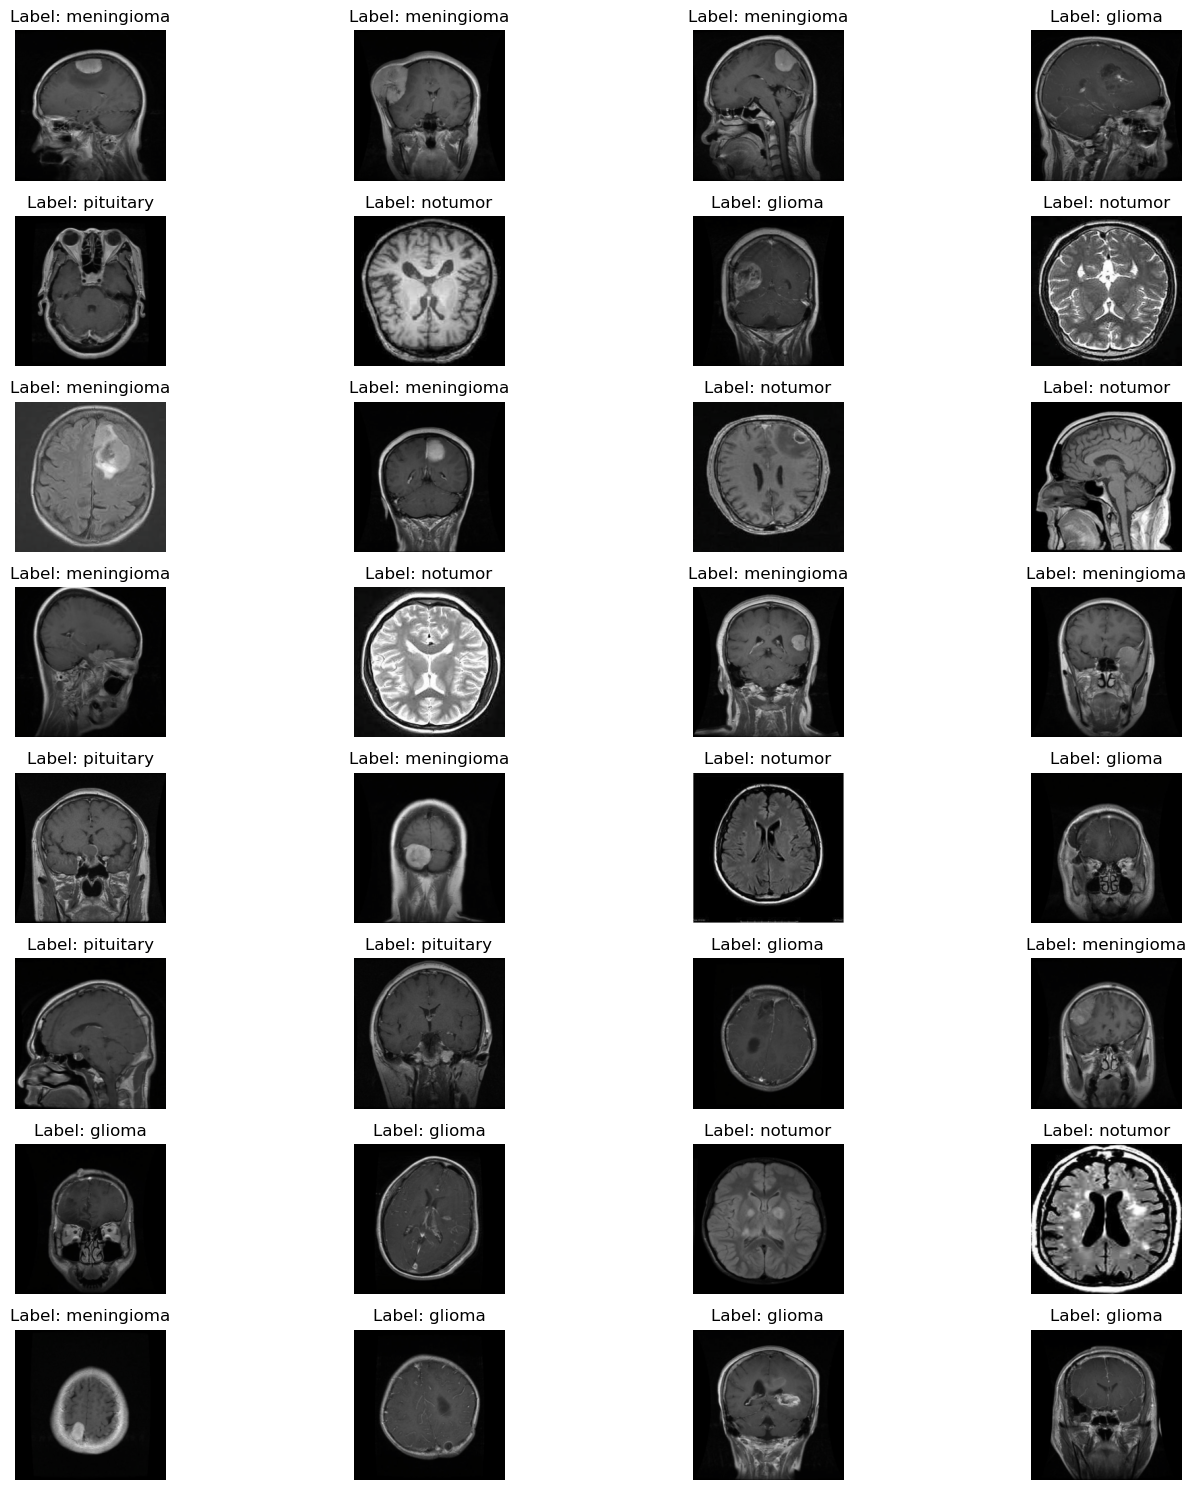

In [20]:
# Iterate through training dataset 
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Denormalize the images (since we did so during the transform)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# Change image format to support Matplotlib, denormalize, and clip pixel values b/w [0,1]
images = (images.numpy().transpose((0,2,3,1)) * std + mean).clip(0,1)

# Create a grid of images
num_images_in_batch = len(images)
rows = int(np.ceil(num_images_in_batch / 4))
# Create a figure (rows * 4) = (8 * 4)
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images_in_batch:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()